# Clustering of Smart Contracts

### Import modules

In [1]:
import json
from pprint import pprint
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import fcluster

from sklearn.decomposition import PCA
from sklearn.neighbors import DistanceMetric
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from nltk.corpus import stopwords
# additional set up
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)
pd.set_option('max_colwidth', -1)
pd.set_option('max_rows', 200)

Using TensorFlow backend.


### Read Data Set and Prepare

In [2]:
df = pd.read_csv('./contracts_source_codes.csv')
df.dropna(subset=['comments'], inplace=True)
df.dropna(subset=['contract_name'], inplace=True)
df.dropna(subset=['comments'], inplace=True)

In [3]:
def clean_text(text):
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text.split() if not w in stops and len(w)>=3]
    text = " ".join(text)
    return(text)

### Clustering on comments of the source code

In [4]:
# text preprocessing
text = df.comments.apply(clean_text)
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(text)
train_X = tokenizer.texts_to_sequences(text)
train_X = [np.unique(i) for i in train_X]
train_X = pad_sequences(train_X, maxlen=200, padding='post')
labels =  df.contract_name

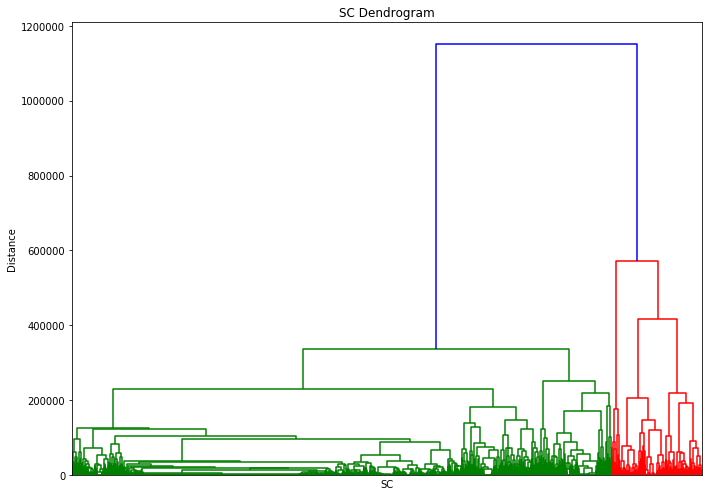

In [5]:
plt.figure(figsize=(10, 7))  
plt.title("SC Dendrogram")  
plt.xlabel('SC')
plt.ylabel('Distance')
Z = shc.linkage(train_X, method='ward')
dend = shc.dendrogram(Z, labels=labels.values, p = 20, no_labels=True) 
plt.tight_layout()
plt.savefig(f'./dendr_small.png', transparent=True)

### Visualisation of Clusters using tSNE (t-distributed stochastic neighbor embedding)

In [6]:
tsne = TSNE(n_components=2)
tsne.fit(train_X)
X_t = tsne.fit_transform(train_X)

In [7]:
max_d = 7
kmeans = KMeans(n_clusters=max_d, random_state=0).fit(X_t)
kmeans.labels_

array([4, 1, 2, ..., 4, 4, 0], dtype=int32)

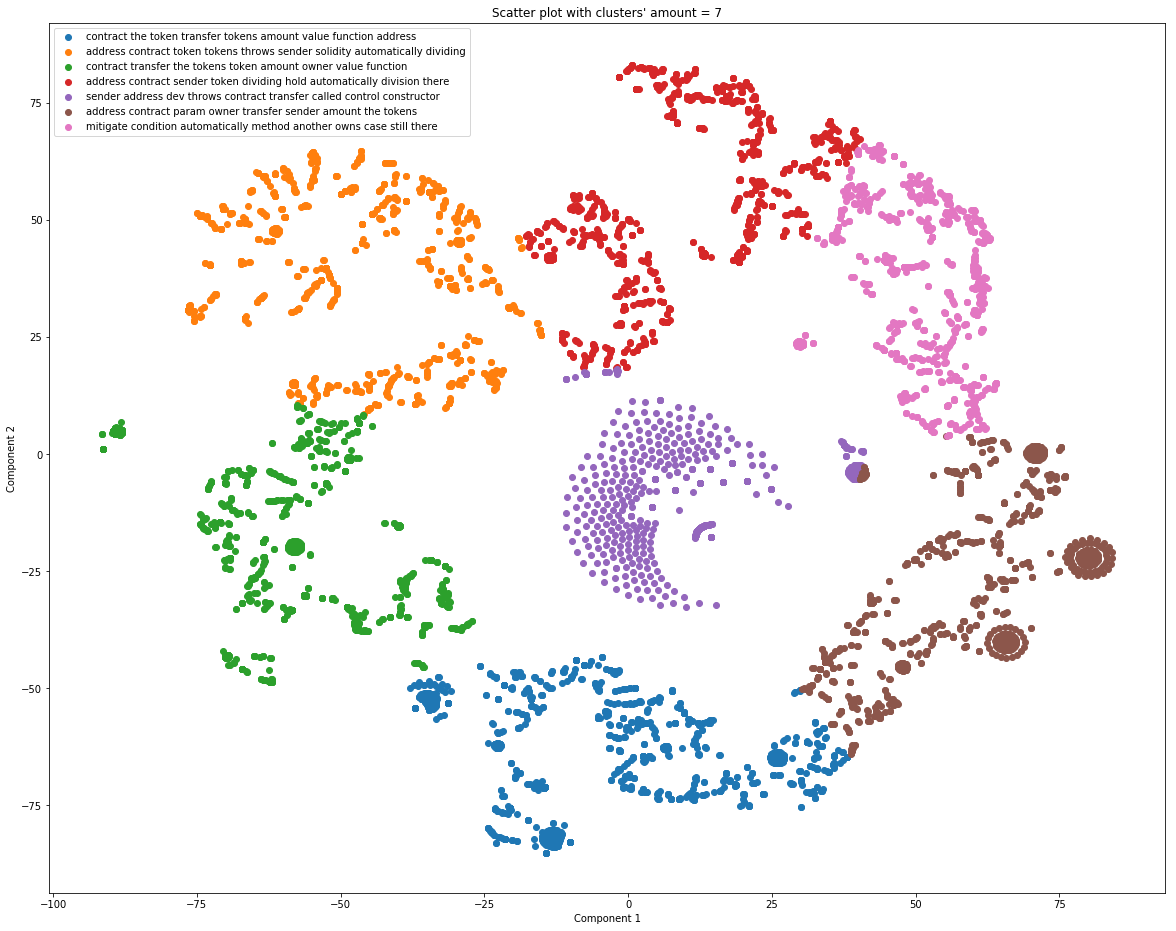

In [8]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
cluster_labels = {}  
for i in range(0, max_d+1):
    df_ = pd.DataFrame(columns = ['word', 'count'])
    df_['word'], df_['count'] = np.unique(train_X[kmeans.labels_==i], return_counts=True)
    df_ = df_.sort_values(by=['count'], ascending=False)
    #print(df.head(20))
    temp = []
    for word in df_.word.values[1:10]:
        temp.append(reverse_word_map[word])
    cluster_labels[i] = ' '.join(temp)
plt.figure(figsize=(20, 16))

for i in range(0, max_d+1):
    plt.scatter(X_t[kmeans.labels_==i,0], X_t[kmeans.labels_==i,1], label = cluster_labels[i])
plt.legend(loc = 'upper left', prop={'size': 10})
#plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), prop={'size': 10})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f'Scatter plot with clusters\' amount = {max_d}')
filename=f'./TSNE_on_{max_d}_clusters_comments.png'
plt.savefig(filename, dpi=96, transparent=True)
plt.gca()

### Clustering on source code

In [9]:
def clean_text(text):
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text.split() if not w in stops and len(w)>=3]
    text = " ".join(text)
    return(text)
text = df.code_all_no_punct.apply(clean_text)

# text preprocessing
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(text)
train_X = tokenizer.texts_to_sequences(text)
train_X = [np.unique(i) for i in train_X]
train_X = pad_sequences(train_X, maxlen=200, padding='post')
labels =  df.contract_name

In [10]:
tsne = TSNE(n_components=2)
tsne.fit(train_X)
X_t = tsne.fit_transform(train_X)
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [11]:
max_d = 7
kmeans = KMeans(n_clusters=max_d, random_state=0).fit(X_t)

array([3, 0, 5, ..., 3, 5, 2], dtype=int32)

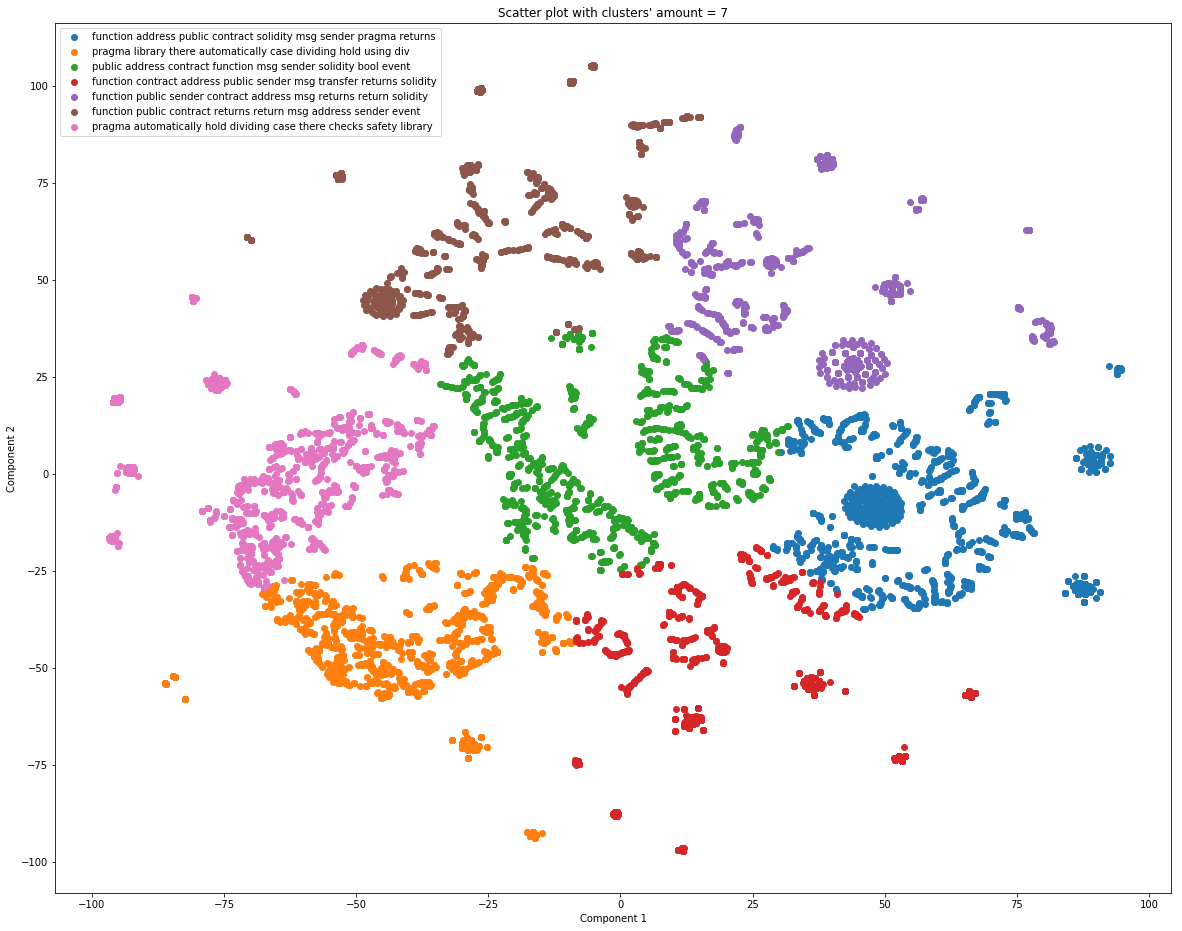

In [12]:
cluster_labels = {}  
for i in range(0, max_d+1):
    df_ = pd.DataFrame(columns = ['word', 'count'])
    df_['word'], df_['count'] = np.unique(train_X[kmeans.labels_==i], return_counts=True)
    df_ = df_.sort_values(by=['count'], ascending=False)
    #print(df.head(20))
    temp = []
    for word in df_.word.values[1:10]:
        temp.append(reverse_word_map[word])
    cluster_labels[i] = ' '.join(temp)

plt.figure(figsize=(20, 16))
for i in range(0, max_d+1):
    plt.scatter(X_t[kmeans.labels_==i,0], X_t[kmeans.labels_==i,1], label = cluster_labels[i])
plt.legend(loc = 'upper left', prop={'size': 10})
#plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8), prop={'size': 10})
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title(f'Scatter plot with clusters\' amount = {max_d}')
filename=f'./TSNE_on_{max_d}_clusters_sourcecode.png'
plt.savefig(filename, dpi=96, transparent=True)
plt.gca()